In [ ]:
# %% Deep learning - Section 11.111
#    Code challenge 16: MNIST and breadth vs. depth

#    1) Start from code from video 11.107, 07.055, and 07.057
#    2) Vary systematically the number of hidden layers from 1 to 3
#    3) Vary systematically the number of units for layers from 50 to 250 in
#       steps of 50 (use same number of units per layer)
#    4) Plot final accuracy from train and test, against number of hidden units,
#       for 1, 2, or 3 hidden layers

# This code pertains a deep learning course provided by Mike X. Cohen on Udemy:
#   > https://www.udemy.com/course/deeplearning_x
# The "base" code in this repository is adapted (with very minor modifications)
# from code developed by the course instructor (Mike X. Cohen), while the
# "exercises" and the "code challenges" contain more original solutions and
# creative input from my side. If you are interested in DL (and if you are
# reading this statement, chances are that you are), go check out the course, it
# is singularly good.


In [ ]:
# %% Libraries and modules
import numpy               as np
import matplotlib.pyplot   as plt
import torch
import torch.nn            as nn
import seaborn             as sns
import copy
import torch.nn.functional as F
import pandas              as pd
import scipy.stats         as stats
import time

from torch.utils.data                 import DataLoader,TensorDataset
from sklearn.model_selection          import train_test_split
from google.colab                     import files
from torchsummary                     import summary
from IPython                          import display
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')


In [ ]:
# %% Data

# Load data
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# Split labels from data
labels = data[:,0]
data   = data[:,1:]

# Normalise data (original range is (0,255))
data_norm = data / np.max(data)


In [ ]:
# %% Create train and test datasets

# Convert to tensor (float and integers)
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

# Split data with scikitlearn (10% test data)
train_data,test_data,train_labels,test_labels = train_test_split(data_tensor,labels_tensor,test_size=0.1)

# Convert to PyTorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Convert into DataLoader objects
batch_size   = 32
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [ ]:
# %% Function to generate the model
#    Flexibly loop over model depth/breadth

def gen_model(nUnits,nLayers,drop_rate):

    class mnist_FFN(nn.Module):
        def __init__(self,nUnits,nLayers,dropout_rate):
            super().__init__()

            # Dictionary to store the layers
            self.layers  = nn.ModuleDict()
            self.nLayers = nLayers

            # Dropout
            self.dropout_rate = dropout_rate

            # Architecture
            self.layers['input'] = nn.Linear(784,nUnits)
            for i in range(nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
            self.layers['output'] = nn.Linear(nUnits,10)

        # Forward propagation
        def forward(self,x):

            x = F.relu(self.layers['input'](x))
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

            for i in range(self.nLayers):
                x = F.relu(self.layers[f'hidden{i}'](x))
                x = F.dropout(x, p=self.dropout_rate, training=self.training)

            x = self.layers['output'](x)

            return x

    # Create model instance
    ANN = mnist_FFN(nUnits,nLayers,drop_rate)

    # Loss function
    loss_fun = nn.CrossEntropyLoss()

    # Optimizer (SGD to slow down learning for illustration purpose)
    optimizer = torch.optim.SGD(ANN.parameters(),lr=0.01)

    return ANN,loss_fun,optimizer


In [ ]:
# %% Generate an instance of the model and check it

nUnitsPerLayer = 10
nLayers        = 2

model, loss_fun, optimizer = gen_model(nUnitsPerLayer,nLayers,0.25)
model


mnist_FFN(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=10, bias=True)
    (hidden0): Linear(in_features=10, out_features=10, bias=True)
    (hidden1): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
# %% Run the model to check its internal consistency

# Samples and dimentions
tmpx = torch.randn(6,784)

# Run the model
y = model(tmpx)

# Show the output shape and the output
print(y.shape)
print()
print(y)


torch.Size([6, 10])

tensor([[-0.2633, -0.0475, -0.1028, -0.0233,  0.1143, -0.2242,  0.1882,  0.0861,
         -0.1753, -0.1293],
        [-0.4195, -0.0440, -0.0538,  0.0250,  0.0985, -0.3073,  0.1706,  0.0661,
         -0.1272, -0.1307],
        [-0.2261, -0.0753, -0.0170, -0.0370,  0.0160, -0.2835,  0.2430,  0.0556,
         -0.2313, -0.1473],
        [-0.4277,  0.0110, -0.0170,  0.0514,  0.0523, -0.2597,  0.1905,  0.0440,
         -0.1454, -0.1144],
        [-0.2181,  0.0306,  0.0610, -0.0564, -0.1498, -0.1168,  0.3748, -0.0539,
         -0.2334, -0.0467],
        [-0.2216, -0.0030,  0.1125,  0.0271, -0.1135, -0.2813,  0.2513, -0.0287,
         -0.2899, -0.1104]], grad_fn=<AddmmBackward0>)


In [ ]:
# %% Function to train the model

def train_model(nUnits,nLayers,drop_rate):

    # Parameters, model instance, inizialise vars
    num_epochs = 60
    ANN,loss_fun,optimizer = gen_model(nUnits,nLayers,drop_rate)

    losses    = []
    train_acc = []
    test_acc  = []

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training batches
        batch_acc  = []
        batch_loss = []

        for X,y in train_loader:

            # Forward propagation and loss
            yHat = ANN(X)
            loss = loss_fun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy from this batch
            batch_loss.append(loss.item())

            matches     = torch.argmax(yHat,axis=1) == y
            matches_num = matches.float()
            accuracy    = 100 * torch.mean(matches_num)
            batch_acc.append(accuracy)

        losses.append( np.mean(batch_loss) )
        train_acc.append( np.mean(batch_acc) )

        # Test accuracy
        ANN.eval()

        with torch.no_grad():
            X,y = next(iter(test_loader))
            yHat = ANN(X)
            test_acc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

        ANN.train()

    return train_acc,test_acc,losses,ANN


In [ ]:
# %% Test the whole setting

train_acc,test_acc,losses,ANN = train_model(32,2,0.25)

print(train_acc[-1])
print(test_acc[-1])


91.37011
tensor(90.2000)


In [ ]:
# %% Parametric experiment on model depth and breadth
#    This cell takes ~ 14 mins

# Define model parameters (num of hidden layers and units per hidden layer)
num_layers = np.linspace(1,3,3,dtype=int)
num_units  = np.linspace(50,250,5,dtype=int)
drop_rate  = 0.25

# Preallocate output matrices
accuracies_train = np.zeros(( len(num_units),len(num_layers) ))
accuracies_test  = np.zeros(( len(num_units),len(num_layers) ))
training_times   = np.zeros(( len(num_units),len(num_layers) ))

# Buckle up, here's the experiment!
for unit_i in range(len(num_units)):
    for layer_i in range(len(num_layers)):

        start_time = time.time()

        # Run model and store outputs
        train_acc,test_acc,losses,ANN = train_model(num_units[unit_i],num_layers[layer_i],drop_rate)

        duration = time.time() - start_time

        # Store accuracies as average accuracy over last 5 epochs, and time
        accuracies_train[unit_i,layer_i] = np.mean(train_acc[-5:])
        accuracies_test[unit_i,layer_i]  = np.mean(test_acc[-5:])
        training_times[unit_i,layer_i]   = duration


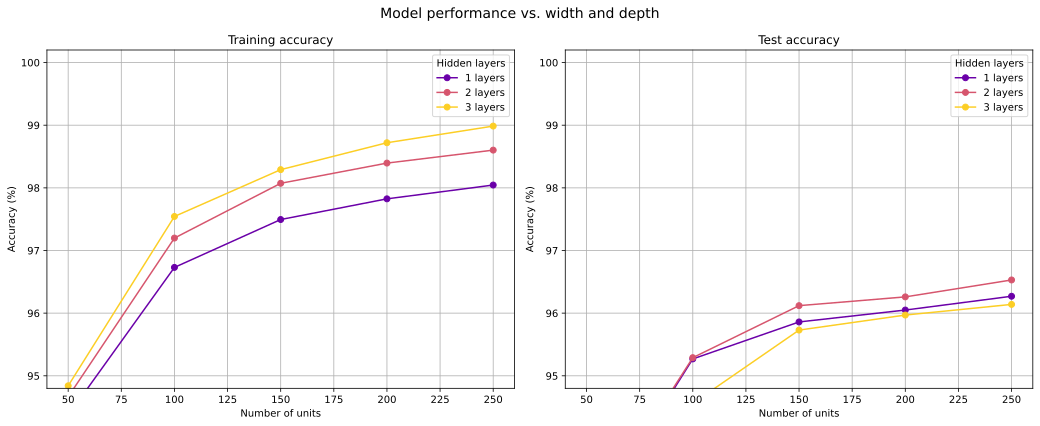

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% Plotting

phi = ( 1 + np.sqrt(5) ) / 2
fig, axs = plt.subplots(1,2,figsize=(1.5*6*phi,6))

cmaps = plt.cm.plasma(np.linspace(.2,.9,len(num_layers)))

# Plot for Training Accuracy
for i, nl in enumerate(num_layers):
    axs[0].plot(num_units,accuracies_train[:, i],'-o',color=cmaps[i],label=f'{int(nl)} layers')
axs[0].set_title('Training accuracy')
axs[0].set_xlabel('Number of units')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(title='Hidden layers')
axs[0].grid(True)
axs[0].set_ylim(94.8,100.2)

# Plot for Test Accuracy
for i, nl in enumerate(num_layers):
    axs[1].plot(num_units,accuracies_test[:,i],'-o',color=cmaps[i],label=f'{int(nl)} layers')
axs[1].set_title('Test accuracy')
axs[1].set_xlabel('Number of units')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend(title='Hidden layers')
axs[1].grid(True)
axs[1].set_ylim(94.8,100.2)

plt.suptitle('Model performance vs. width and depth', fontsize=14)
plt.tight_layout()

plt.savefig('figure41_code_challenge_16.png')

plt.show()

files.download('figure41_code_challenge_16.png')


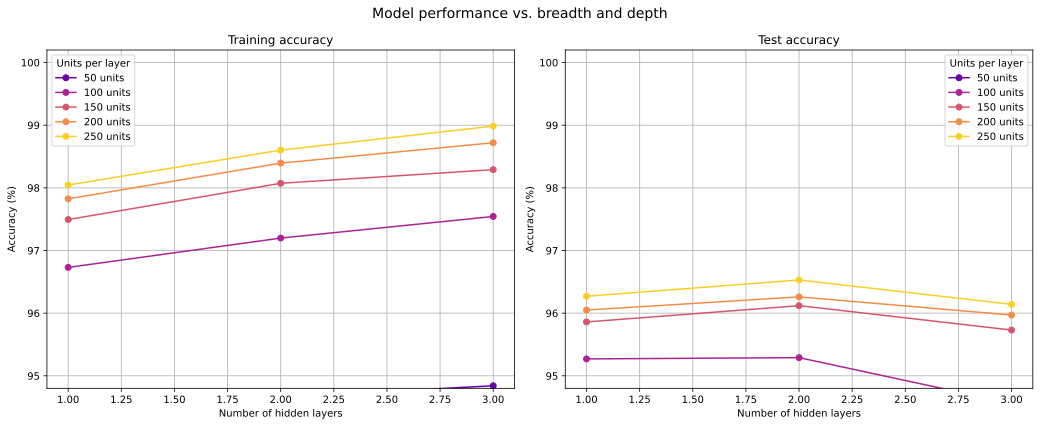

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% Plotting

phi = ( 1 + np.sqrt(5) ) / 2
fig, axs = plt.subplots(1,2,figsize=(1.5*6*phi,6))

cmaps = plt.cm.plasma(np.linspace(.2,.9,len(num_units)))

# Plot for Training Accuracy
for i,n_units in enumerate(num_units):
    axs[0].plot(num_layers,accuracies_train[i,:],'-o',color=cmaps[i],label=f'{int(n_units)} units')
axs[0].set_title('Training accuracy')
axs[0].set_xlabel('Number of hidden layers')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(title='Units per layer')
axs[0].grid(True)
axs[0].set_ylim(94.8,100.2)

# Plot for Test Accuracy
for i,n_units in enumerate(num_units):
    axs[1].plot(num_layers,accuracies_test[i,:],'-o',color=cmaps[i],label=f'{int(n_units)} units')
axs[1].set_title('Test accuracy')
axs[1].set_xlabel('Number of hidden layers')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend(title='Units per layer')
axs[1].grid(True)
axs[1].set_ylim(94.8,100.2)

plt.suptitle('Model performance vs. breadth and depth',fontsize=14)
plt.tight_layout()

plt.savefig('figure42_code_challenge_16.png')

plt.show()

files.download('figure42_code_challenge_16.png')


In [ ]:
# %% Exercise 1
#    Based on the results above, pick the best and the worst model architectures.
#    Then, run only those two models again using regularization (you can pick which
#    regularization method to use). Does this help the bad model and/or hurt the good model?

# A bit of a lazy approach here. I re-ran everything using a dropout
# regularisation, with a value of 0.25. Interestingly, for these data set, the
# regularisation seems to worsen the training accuracy in general (which is
# indeed expected), but is also seems to worsen the test accuracy, especially
# for models with fewer units; I'd guess this is can be at least partially
# explained because with fewer units in general, a constant dropout rate is a
# bit more brutal than for models with more units.


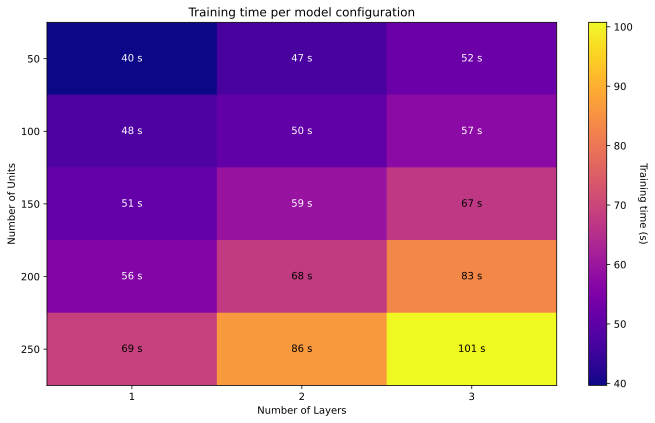

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% Exercise 2
#    Time how long each model takes to train (from the full experiment, not just the two models
#    for exploration #1). Obviously, both factors (depth and breadth) affect training time, but
#    which factor seems to have a bigger influence on model training time?

# Results based on dropout regularisation values of 0 and 0.25. Regularisation
# greater than 0 takes a bit more time in general, but most importantly there
# seems to be a mild moderation by number of layers, and a stronger moderation
# by number of units.

# Plot time matrix
fig, ax = plt.subplots(figsize=(phi*6,6))
im = ax.imshow(training_times,cmap='plasma',aspect='auto')

ax.set_xticks(range(len(num_layers)))
ax.set_xticklabels([int(n) for n in num_layers])
ax.set_xlabel('Number of Layers')

ax.set_yticks(range(len(num_units)))
ax.set_yticklabels([int(n) for n in num_units])
ax.set_ylabel('Number of Units')

cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Training time (s)',rotation=270,labelpad=15)

for i in range(len(num_units)):
    for j in range(len(num_layers)):
        value = training_times[i,j]
        ax.text(j,i,f'{value:.0f} s',ha='center',va='center',color='white' if value < np.max(training_times)*0.6 else 'black')

ax.set_title('Training time per model configuration')
plt.tight_layout()

plt.savefig('figure45_code_challenge_16_extra2.png')

plt.show()

files.download('figure45_code_challenge_16_extra2.png')
